# Definitive Merger of Startup Databases

This notebook merges the startup anagrafica dataset with the crunchbase dataset using fuzzy matching on company names.

In [1]:
import pandas as pd
import numpy as np
import re
from thefuzz import process, fuzz
from src.ingestion import download_from_drive
from tqdm.notebook import tqdm

In [2]:
# PAY ATTENTION: if not updated, it will overwrite the files

# set starting db links
df_crunchbase = pd.read_csv('data/df_unmerged_companies.csv')
df_aida = download_from_drive("aida_2018_descrizione")

# set names of the files where the results will be saved
df_merged_companies = "df_merged_companies_2.csv"
df_unmerged_companies = "df_unmerged_companies_2.csv"


In [3]:
# Load the databases
df_anagrafica = df_aida
#df_anagrafica = download_from_drive("csv_startup_anagrafica")
#df_crunchbase = download_from_drive("estrazione_crunchbase_5k")

# Display the first few rows of each dataframe
print("Startup Anagrafica Dataset:")
display(df_anagrafica.head())

print("\nCrunchbase Dataset:")
display(df_crunchbase.head())

Startup Anagrafica Dataset:


,Unnamed: 0,Ragione sociale,BvD ID number,Codice fiscale,Numero CCIAA,Partita IVA,Indirizzo sede legale,Provincia,Indirizzo sede legale - Codice postale,Indirizzo sede legale - Regione,Sede operativa,Sede operativa - Provincia,Sede operativa - Codice postale,Sede operativa - Regione - Regione,ATECO 2007\ncodice,Anno di costituzione,Fondazione,Stato giuridico,Forma giuridica
0,1.0,ADI SERVIZI MARITTIMI S.R.L.,IT10354920968,10354920968,MI2525097,1.035492e+10,"VLE CERTOSA, 239",Milano,20151.0,Lombardia,VIALE CERTOSA 239,Milano,20151.0,LOMBARDIA,502000.0,18/05/2018,NaN,Attiva (Stato di insolvenza),S.R.L.
1,2.0,ACCIAIERIE D'ITALIA S.P.A.,IT10354890963,10354890963,MI2525101,1.035489e+10,"VLE CERTOSA, 239",Milano,20151.0,Lombardia,VIALE CERTOSA 239,Milano,20151.0,LOMBARDIA,241000.0,18/05/2018,NaN,Attiva (Stato di insolvenza),S.P.A.
2,3.0,ADI ENERGIA S.R.L.,IT10354910969,10354910969,MI2525096,1.035491e+10,"VLE CERTOSA, 239",Milano,20151.0,Lombardia,VIALE CERTOSA 239,Milano,20151.0,LOMBARDIA,351100.0,18/05/2018,NaN,Attiva (Stato di insolvenza),S.R.L.
3,4.0,TECUM SOCIETA' COOPERATIVA SOCIALE,IT15907261000,15907261000,RM1622339,1.590726e+10,"PZA VITTORIO EMANUELE II, 138",Roma,185.0,Lazio,NaN,NaN,NaN,NaN,881000.0,03/11/2020,NaN,In liquidazione,S.C.A.R.L.P.A.
4,5.0,ITALMETAL GROUP SRL IN LIQUIDAZIONE,IT14825331003,14825331003,PR0285439,1.482533e+10,"PZA SISTO ROSA BADALOCCHIO, 9/B",Parma,43126.0,Emilia-Romagna,PIAZZA SISTO ROSA BADALOCCHIO 9/B,Parma,43126.0,EMILIA-ROMAGNA,479110.0,01/06/2018,NaN,In liquidazione,S.R.L.



Crunchbase Dataset:


,Organization Name,Organization Name URL,IPO Status,Company Type,Industries,Number of Employees,Headquarters Location,CB Rank (Organization),Stage,CB Rank (Company),...,Exit Date,Exit Date Precision,Founded Date,Founded Date Precision,Operating Status,Description,Estimated Revenue Range,Postal Code,Headquarters Regions,Number of Portfolio Organizations
0,Enilive,https://www.crunchbase.com/organization/enilive,Private,For Profit,"Biofuel, Car Sharing, Energy Efficiency, Trans...",1001-5000,"Roma, Lazio, Italy","1,495",NaN,"1,173",...,NaN,NaN,2023-01-01,year,Active,Enilive is Eni's mobility transformation compa...,NaN,144,"European Union (EU), Europe, Middle East, and ...",NaN
1,Electrolux Professional,https://www.crunchbase.com/organization/electr...,Public,For Profit,"Laundry and Dry-cleaning, Machinery Manufacturing",1001-5000,"Pordenone, Friuli-Venezia Giulia, Italy","3,453",NaN,"2,808",...,2020-05-27,day,2019-01-01,day,Active,Electrolux Professional is a global provider o...,$1B to $10B,NaN,"European Union (EU), Europe, Middle East, and ...",NaN
2,Akamas,https://www.crunchbase.com/organization/akamas,Private,For Profit,"Analytics, Application Performance Management,...",11-50,"Milan, Lombardia, Italy","4,411",NaN,"3,623",...,NaN,NaN,2019-01-01,year,Active,Akamas AI safely optimizes application workloa...,$1M to $10M,20158,"European Union (EU), Europe, Middle East, and ...",NaN
3,Cardo AI,https://www.crunchbase.com/organization/cardo-ai,Private,For Profit,"Artificial Intelligence (AI), Financial Servic...",101-250,"Milan, Lombardia, Italy","4,768",NaN,"3,911",...,NaN,NaN,2018-01-01,year,Active,Cardo AI is a fintech company that offers arti...,$10M to $50M,20122,"European Union (EU), Europe, Middle East, and ...",NaN
4,Fabrick,https://www.crunchbase.com/organization/fabrick,Private,For Profit,"Banking, Finance, Financial Services, FinTech,...",251-500,"Milan, Lombardia, Italy","6,525",NaN,"5,454",...,NaN,NaN,2018-01-01,year,Active,Fabrick is a financial services company that o...,$1M to $10M,20124,"European Union (EU), Europe, Middle East, and ...",12.0


In [4]:
def pulisci_stringa(s: str) -> str:
    """
    Enhanced string cleaning function with more sophisticated preprocessing
    for better company name matching.
    """
    if not isinstance(s, str):
        if s is None:
            return ""
        else:
            return str(s)
    
    s = s.strip().lower()
    
    # Handle common company type abbreviations (more comprehensive list)
    s = re.sub(r'\b(srl|s\.r\.l|s\.r\.l\.|s.r.l|spa|s\.p\.a|s\.p\.a\.|s.p.a|' + 
               r'inc|incorporated|llc|ltd|limited|gmbh|' + 
               r'corp|corporation|co\.|company|group|holding|' + 
               r'sas|sapa|snc|scarl)(?=\s|$|\b)', '', s)
    
    # Handle common abbreviations
    s = s.replace("int'l", "international")
    s = s.replace("tech.", "technology")
    s = s.replace("tech", "technology")
    s = s.replace("&", "and")
    
    # Remove geographical designations that might differ
    s = re.sub(r'\b(italy|italia|italian|italiano|italiana)\b', '', s)
    
    # Remove special characters and extra spaces
    s = re.sub(r'[^\w\s]', ' ', s)
    
    # Remove common filler words
    s = re.sub(r'\b(the|di|del|della|e|a|in|for|of)\b', ' ', s)
    
    # Replace multiple spaces with single space and trim
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

def calculate_composite_score(name1, name2):
    """
    Calculate a composite score using multiple string matching algorithms
    to better identify company name matches.
    
    Returns: float between 0-100 representing match confidence
    """
    # Standard ratios check different aspects of string similarity
    ratio = fuzz.ratio(name1, name2)
    partial_ratio = fuzz.partial_ratio(name1, name2)
    token_sort_ratio = fuzz.token_sort_ratio(name1, name2)
    token_set_ratio = fuzz.token_set_ratio(name1, name2)
    
    # Calculate a weighted average - giving more weight to token methods
    # as they handle word order differences better for company names
    weighted_score = (
        ratio * 0.15 +
        partial_ratio * 0.25 +
        token_sort_ratio * 0.3 +
        token_set_ratio * 0.3
    )
    
    # Additional bonus for exact token matching
    tokens1 = set(name1.split())
    tokens2 = set(name2.split())
    
    # If there are significant shared tokens, boost the score
    if len(tokens1) > 0 and len(tokens2) > 0:
        shared = tokens1.intersection(tokens2)
        if len(shared) >= 2:  # At least 2 significant words match
            weighted_score += min(10, len(shared) * 2.5)  # Bonus up to 10 points
    
    # Cap at 100
    return min(100, weighted_score)

def enhanced_fuzzy_merge(
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    key1: str,
    key2: str,
    threshold: int = 75
) -> pd.DataFrame:
    """
    Enhanced version of fuzzy_merge that uses multiple matching techniques
    for more accurate company name matching.
    """
    # Copia dei DataFrame per non modificare gli originali
    df1_clean = df1.copy()
    df2_clean = df2.copy()
    
    # Creiamo colonne "pulite" per il matching con la funzione migliorata
    df1_clean['key_clean'] = df1_clean[key1].apply(pulisci_stringa)
    df2_clean['key_clean'] = df2_clean[key2].apply(pulisci_stringa)
    
    # Create clean keys and make a dictionary for lookup
    unique_keys2 = df2_clean['key_clean'].unique().tolist()
    
    # Lista per salvare i risultati
    risultati = []
    
    # Track already matched names in df2 to avoid duplicates
    matched_df2_indices = set()

    for idx1, row in tqdm(df1_clean.iterrows(), total=len(df1_clean), desc="Matching records"):
        name_to_match = row['key_clean']
        
        # Skip empty names
        if not name_to_match.strip():
            continue
            
        # Get top 5 potential matches instead of just one
        top_matches = process.extract(name_to_match, unique_keys2, 
                                     scorer=fuzz.token_set_ratio, limit=5)
        
        best_match = None
        best_score = 0
        best_match_row = None
        
        # Evaluate each potential match with our composite score
        for match_name, base_score in top_matches:
            # Calculate more sophisticated score
            composite_score = calculate_composite_score(name_to_match, match_name)
            
            # Find matching rows
            match_rows = df2_clean[df2_clean['key_clean'] == match_name]
            
            # Skip if we've already used all these matches
            if all(idx in matched_df2_indices for idx in match_rows.index):
                continue
                
            # Get first available match
            for idx2, match_row in match_rows.iterrows():
                if idx2 not in matched_df2_indices and composite_score > best_score:
                    best_score = composite_score
                    best_match = match_name
                    best_match_row = match_row
                    best_match_idx = idx2
                    break
        
        # Process the best match if it meets the threshold
        if best_match and best_score >= threshold:
            # Mark this df2 row as matched
            matched_df2_indices.add(best_match_idx)
            
            # Build combined data dictionary
            combined_data = {}
            
            # Data from df1
            for col in df1_clean.columns:
                if col != 'key_clean':  # Exclude auxiliary column
                    combined_data[f"anagrafica_{col}"] = row[col]
            
            # Data from df2
            for col in df2_clean.columns:
                if col != 'key_clean':  # Exclude auxiliary column
                    combined_data[f"crunchbase_{col}"] = best_match_row[col]
            
            combined_data['similarity_score'] = best_score
            combined_data['composite_match'] = True
            
            risultati.append(combined_data)
        else:
            # If no good match, keep just df1 data
            combined_data = {}
            for col in df1_clean.columns:
                if col != 'key_clean':
                    combined_data[f"anagrafica_{col}"] = row[col]
            
            for col in df2_clean.columns:
                if col != 'key_clean':
                    combined_data[f"crunchbase_{col}"] = None
                    
            combined_data['similarity_score'] = best_score if best_score else 0
            combined_data['composite_match'] = False
            risultati.append(combined_data)
    
    # Add remaining df2 rows that weren't matched
    if len(matched_df2_indices) < len(df2_clean):
        for idx2, row in df2_clean.iterrows():
            if idx2 not in matched_df2_indices:
                combined_data = {}
                
                # Empty df1 data
                for col in df1_clean.columns:
                    if col != 'key_clean':
                        combined_data[f"anagrafica_{col}"] = None
                
                # df2 data
                for col in df2_clean.columns:
                    if col != 'key_clean':
                        combined_data[f"crunchbase_{col}"] = row[col]
                
                combined_data['similarity_score'] = 0
                combined_data['composite_match'] = False
                risultati.append(combined_data)
    
    # Convert to DataFrame
    df_risultati = pd.DataFrame(risultati)
    return df_risultati

In [5]:
# Ensure ipywidgets is installed to fix the IProgress error
#%pip install ipywidgets

# Eseguiamo il merge con una soglia appropriata
df_merged = enhanced_fuzzy_merge(df_anagrafica, df_crunchbase, "Ragione sociale", "Organization Name", threshold=85)

# Visualizziamo un campione dei risultati
print(f"Numero di record totali dopo il merge: {len(df_merged)}")
df_merged.head()

Matching records:   0%|          | 0/6566 [00:00<?, ?it/s]

Numero di record totali dopo il merge: 9709


,anagrafica_Unnamed: 0,anagrafica_Ragione sociale,anagrafica_BvD ID number,anagrafica_Codice fiscale,anagrafica_Numero CCIAA,anagrafica_Partita IVA,anagrafica_Indirizzo sede legale,anagrafica_Provincia,anagrafica_Indirizzo sede legale - Codice postale,anagrafica_Indirizzo sede legale - Regione,...,crunchbase_Founded Date,crunchbase_Founded Date Precision,crunchbase_Operating Status,crunchbase_Description,crunchbase_Estimated Revenue Range,crunchbase_Postal Code,crunchbase_Headquarters Regions,crunchbase_Number of Portfolio Organizations,similarity_score,composite_match
0,1.0,ADI SERVIZI MARITTIMI S.R.L.,IT10354920968,1.035492e+10,MI2525097,1.035492e+10,"VLE CERTOSA, 239",Milano,20151.0,Lombardia,...,None,None,None,None,None,None,None,NaN,69.10,False
1,2.0,ACCIAIERIE D'ITALIA S.P.A.,IT10354890963,1.035489e+10,MI2525101,1.035489e+10,"VLE CERTOSA, 239",Milano,20151.0,Lombardia,...,None,None,None,None,None,None,None,NaN,60.50,False
2,3.0,ADI ENERGIA S.R.L.,IT10354910969,1.035491e+10,MI2525096,1.035491e+10,"VLE CERTOSA, 239",Milano,20151.0,Lombardia,...,None,None,None,None,None,None,None,NaN,83.00,False
3,4.0,TECUM SOCIETA' COOPERATIVA SOCIALE,IT15907261000,1.590726e+10,RM1622339,1.590726e+10,"PZA VITTORIO EMANUELE II, 138",Roma,185.0,Lazio,...,None,None,None,None,None,None,None,NaN,67.75,False
4,5.0,ITALMETAL GROUP SRL IN LIQUIDAZIONE,IT14825331003,1.482533e+10,PR0285439,1.482533e+10,"PZA SISTO ROSA BADALOCCHIO, 9/B",Parma,43126.0,Emilia-Romagna,...,None,None,None,None,None,None,None,NaN,52.15,False


In [6]:
# Creiamo un ID unico per ogni coppia abbinata
# Utilizziamo una combinazione dei valori originali per creare un ID significativo

def create_unique_id(row):
    # Prendiamo il nome dalla colonna anagrafica se disponibile, altrimenti da crunchbase
    company_name = str(row['anagrafica_Ragione sociale']) if pd.notna(row['anagrafica_Ragione sociale']) else \
                  str(row['crunchbase_Organization Name']) if pd.notna(row['crunchbase_Organization Name']) else 'unknown'
    
    # Pulizia base per l'ID
    clean_name = re.sub(r'[^\w]', '', company_name.lower())
    
    # Aggiungiamo un valore numerico progressivo per garantire l'unicità
    return f"comp_{clean_name[:20]}"

# Creiamo inizialmente l'ID senza controllo duplicati
df_merged['company_id'] = df_merged.apply(create_unique_id, axis=1)

# Controlliamo e gestiamo i duplicati aggiungendo un numero progressivo
id_counts = df_merged['company_id'].value_counts()
duplicated_ids = id_counts[id_counts > 1].index.tolist()

# Per ogni ID duplicato, aggiungiamo un contatore
for dup_id in duplicated_ids:
    # Identifichiamo tutte le righe con questo ID
    mask = df_merged['company_id'] == dup_id
    # Aggiungiamo un contatore progressivo
    df_merged.loc[mask, 'company_id'] = [
        f"{dup_id}_{i}" for i in range(1, mask.sum() + 1)
    ]

# Verifichiamo che non ci siano più duplicati
print(f"ID unici: {df_merged['company_id'].nunique()}")
print(f"Totale record: {len(df_merged)}")

# Visualizziamo i risultati con i nuovi ID
df_merged[['company_id', 'anagrafica_Ragione sociale', 'crunchbase_Organization Name', 'similarity_score']].head(10)

ID unici: 9709
Totale record: 9709


,company_id,anagrafica_Ragione sociale,crunchbase_Organization Name,similarity_score
0,comp_adiservizimarittimis,ADI SERVIZI MARITTIMI S.R.L.,None,69.10
1,comp_acciaierieditaliaspa,ACCIAIERIE D'ITALIA S.P.A.,None,60.50
2,comp_adienergiasrl,ADI ENERGIA S.R.L.,None,83.00
3,comp_tecumsocietacooperat,TECUM SOCIETA' COOPERATIVA SOCIALE,None,67.75
4,comp_italmetalgroupsrlinl,ITALMETAL GROUP SRL IN LIQUIDAZIONE,None,52.15
5,comp_amgsocietacooperativ,AMG SOCIETA' COOPERATIVA A RESPONSABILITA' LIM...,None,58.50
6,comp_consorziocea,CONSORZIO CEA,None,70.80
7,comp_gknhydrogensrlinliqu,GKN HYDROGEN S.R.L. IN LIQUIDAZIONE/LIQUIDATION,None,82.05
8,comp_develog5srl,DEVELOG 5 S.R.L.,None,70.25
9,comp_admaiorasrlinliquida,AD MAIORA S.R.L. IN LIQUIDAZIONE,None,58.55


In [7]:
# Gestione delle colonne - manteniamo i nomi originali ma riorganizziamo il dataset
# Creiamo un nuovo DataFrame più pulito con le colonne principali

cols_to_keep = [
    'company_id',  # Il nostro ID unico
    'anagrafica_Ragione sociale',
    'crunchbase_Organization Name',
    'similarity_score'
    # Aggiungi qui altre colonne di interesse
]

df_final = df_merged[cols_to_keep].copy()

# Rinominiamo le colonne per chiarezza mantenendo i nomi originali
df_final = df_final.rename(columns={
    'anagrafica_Ragione sociale': 'Ragione sociale',
    'crunchbase_Organization Name': 'Organization Name'
})

# Visualizza il dataset finale
df_final.head()

,company_id,Ragione sociale,Organization Name,similarity_score
0,comp_adiservizimarittimis,ADI SERVIZI MARITTIMI S.R.L.,None,69.10
1,comp_acciaierieditaliaspa,ACCIAIERIE D'ITALIA S.P.A.,None,60.50
2,comp_adienergiasrl,ADI ENERGIA S.R.L.,None,83.00
3,comp_tecumsocietacooperat,TECUM SOCIETA' COOPERATIVA SOCIALE,None,67.75
4,comp_italmetalgroupsrlinl,ITALMETAL GROUP SRL IN LIQUIDAZIONE,None,52.15


In [8]:
# Opzionale: salva il dataset finale
# df_final.to_csv('merged_company_data.csv', index=False)

# Statistiche finali
print(f"Totale record nel dataset finale: {len(df_final)}")
print(f"Record con match di alta qualità (score >= 90): {(df_final['similarity_score'] >= 90).sum()}")
print(f"Record con match medio (score 80-90): {((df_final['similarity_score'] >= 80) & (df_final['similarity_score'] < 90)).sum()}")
print(f"Record con match basso (score < 80): {(df_final['similarity_score'] < 80).sum() if 'similarity_score' in df_final.columns else 'N/A'}")

Totale record nel dataset finale: 9709
Record con match di alta qualità (score >= 90): 132
Record con match medio (score 80-90): 467
Record con match basso (score < 80): 9110


In [9]:
df_final.tail()

,company_id,Ragione sociale,Organization Name,similarity_score
9704,comp_gustochef,None,Gustochef,0.0
9705,comp_fulgurlab,None,Fulgur Lab,0.0
9706,comp_ivyfarm,None,Ivy Farm,0.0
9707,comp_localgreen,None,Local Green,0.0
9708,comp_semplicegasluce,None,Semplice Gas & Luce,0.0


Totale aziende con corrispondenza tra i due database: 280
Totale aziende nel database anagrafica: 6565
Totale aziende nel database crunchbase: 3424
Percentuale di aziende anagrafica con match: 4.27%
Percentuale di aziende crunchbase con match: 8.18%

Esempi di corrispondenze trovate (ordinate per score):


,company_id,anagrafica_Ragione sociale,crunchbase_Organization Name,similarity_score
6064,comp_argeaspa,ARGEA S.P.A.,Argea,100.0
681,comp_victorysrl,VICTORY S.R.L.,Victory,100.0
503,comp_enilivespa,ENILIVE S.P.A.,Enilive,100.0
519,comp_ivisiontechspa,IVISION TECH S.P.A.,iVision Tech,100.0
525,comp_massimaenergiaspa,MASSIMA ENERGIA S.P.A.,Massima Energia,100.0
549,comp_sofeinspa,SOFEIN S.P.A.,Sofein,100.0
592,comp_bidberrysrl,BIDBERRY SRL,BidBerry,100.0
624,comp_scalapaysrl,SCALAPAY S.R.L.,Scalapay,100.0
643,comp_zanichelliventurespa,ZANICHELLI VENTURE S.P.A.,Zanichelli Venture,100.0
228,comp_lafiletteriasrl,LA FILETTERIA S.R.L.,La Filetteria Italiana,100.0


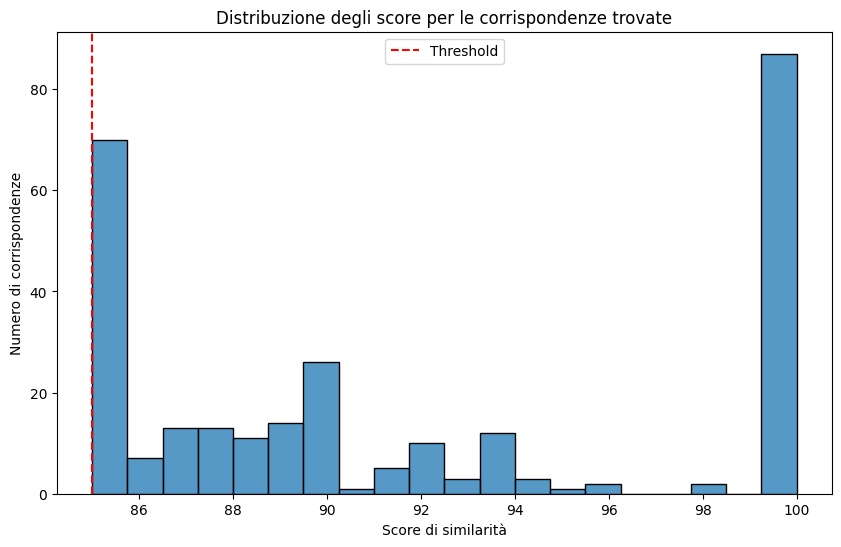

In [10]:
# Conteggio delle corrispondenze tra anagrafica_Ragione sociale e crunchbase_Organization Name

# Filtriamo le righe dove entrambi i campi non sono null
matched_companies = df_merged[
    pd.notna(df_merged['anagrafica_Ragione sociale']) & 
    pd.notna(df_merged['crunchbase_Organization Name'])
]

# Contiamo quante corrispondenze abbiamo trovato
total_matches = len(matched_companies)
total_anagrafica = df_merged['anagrafica_Ragione sociale'].notna().sum()
total_crunchbase = df_merged['crunchbase_Organization Name'].notna().sum()

print(f"Totale aziende con corrispondenza tra i due database: {total_matches}")
print(f"Totale aziende nel database anagrafica: {total_anagrafica}")
print(f"Totale aziende nel database crunchbase: {total_crunchbase}")
print(f"Percentuale di aziende anagrafica con match: {(total_matches / total_anagrafica * 100):.2f}%")
print(f"Percentuale di aziende crunchbase con match: {(total_matches / total_crunchbase * 100):.2f}%")

# Visualizziamo alcuni esempi di corrispondenze con i relativi score
print("\nEsempi di corrispondenze trovate (ordinate per score):")
display(matched_companies[['company_id', 'anagrafica_Ragione sociale', 
                          'crunchbase_Organization Name', 'similarity_score']]
       .sort_values(by='similarity_score', ascending=False).head(10))

# Distribuzione degli score per le corrispondenze trovate
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(matched_companies['similarity_score'], bins=20)
plt.title('Distribuzione degli score per le corrispondenze trovate')
plt.xlabel('Score di similarità')
plt.ylabel('Numero di corrispondenze')
plt.axvline(x=85, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.show()

In [11]:
# Save the df_merged DataFrame to a CSV file in the 'data' folder
df_merged.to_csv(f"data/{df_merged_companies}", index=False)

# Unmerged companies

In [15]:
# Filter rows where "crunchbase_Organization Name" is not null and "anagrafica_Ragione sociale" is null
df_crunchbase_unmerged = df_merged[
    df_merged['crunchbase_Organization Name'].notna() & df_merged['anagrafica_Ragione sociale'].isna()
]

# Select only the columns that begin with "crunchbase_"
df_crunchbase_unmerged = df_crunchbase_unmerged[
    [col for col in df_merged.columns if col.startswith("crunchbase_")]
]

# Rename the columns to remove the "crunchbase_" prefix
df_crunchbase_unmerged.columns = df_crunchbase_unmerged.columns.str.replace('crunchbase_', '', regex=False)
df_crunchbase_unmerged.head()

# Display the resulting DataFrame
df_crunchbase_unmerged.shape

# Save the crunchbase_only_companies DataFrame to a CSV file in the 'data' folder
df_crunchbase_unmerged.to_csv(f"data/{df_unmerged_companies}", index=False)

In [12]:
def extract_unmatched_crunchbase_locations():
    """
    Estrae gli Headquarters Location dal database Crunchbase per le aziende
    che sono presenti solo in Crunchbase (senza corrispondenza in anagrafica).
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame contenente Organization Name e Headquarters Location
        delle aziende che sono solo in Crunchbase
    """
    # Filtriamo le righe dove c'è un valore in crunchbase_Organization Name
    # ma non in anagrafica_Ragione sociale
    unmatched_cb = df_merged[
        pd.notna(df_merged['crunchbase_Organization Name']) & 
        pd.isna(df_merged['anagrafica_Ragione sociale'])
    ].copy()
    
    # Selezioniamo solo le colonne di interesse
    result = unmatched_cb[['crunchbase_Organization Name', 'crunchbase_Headquarters Location']]
    
    # Rinominiamo le colonne per maggiore chiarezza
    result = result.rename(columns={
        'crunchbase_Organization Name': 'Organization Name',
        'crunchbase_Headquarters Location': 'Headquarters Location'
    })
    
    # Riordiniamo e resettiamo l'indice
    result = result.sort_values(by='Organization Name').reset_index(drop=True)
    
    return result

# Eseguiamo la funzione e mostriamo i risultati
unmatched_locations = extract_unmatched_crunchbase_locations()

# Statistiche sulle sedi non corrispondenti
print(f"Totale organizzazioni solo in Crunchbase (senza match in anagrafica): {len(unmatched_locations)}")

# Contiamo la distribuzione delle sedi (top 10)
if 'Headquarters Location' in unmatched_locations.columns and not unmatched_locations.empty:
    location_counts = unmatched_locations['Headquarters Location'].value_counts().head(10)
    print("\nTop 10 sedi delle organizzazioni non corrispondenti:")
    display(location_counts)
    
    # Percentuale di valori mancanti nella colonna Headquarters Location
    missing_pct = unmatched_locations['Headquarters Location'].isna().mean() * 100
    print(f"\nPercentuale di valori mancanti nella colonna 'Headquarters Location': {missing_pct:.2f}%")

# Mostriamo i primi risultati
print("\nEsempi di organizzazioni solo in Crunchbase:")
display(unmatched_locations.head(10))

Totale organizzazioni solo in Crunchbase (senza match in anagrafica): 3144

Top 10 sedi delle organizzazioni non corrispondenti:


Headquarters Location
Milan, Lombardia, Italy           641
Rome, Lazio, Italy                293
Milano, Lombardia, Italy          232
Turin, Piemonte, Italy            107
Roma, Lazio, Italy                 94
Bologna, Emilia-Romagna, Italy     87
Brescia, Lombardia, Italy          69
Torino, Piemonte, Italy            52
Verona, Veneto, Italy              50
Bari, Puglia, Italy                49
Name: count, dtype: int64


Percentuale di valori mancanti nella colonna 'Headquarters Location': 0.00%

Esempi di organizzazioni solo in Crunchbase:


,Organization Name,Headquarters Location
0,#00F Agency,"Milan, Lombardia, Italy"
1,(re)BALANCE,"Milan, Lombardia, Italy"
2,010 Films,"Genoa, Liguria, Italy"
3,01Bee,"Nola, Campania, Italy"
4,100Grammi,"Arcugnano, Veneto, Italy"
5,10punto10,"Milano, Lombardia, Italy"
6,1C ERP,"Milan, Lombardia, Italy"
7,20energy,"Spoleto, Umbria, Italy"
8,247PAY,"Paola, Calabria, Italy"
9,247X,"Rome, Lazio, Italy"


In [13]:
def get_crunchbase_only_companies():
    """
    Estrae i nomi delle aziende che sono presenti solo nel database Crunchbase
    e non hanno corrispondenza nel database Anagrafica.
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame contenente solo i nomi delle aziende presenti esclusivamente in Crunchbase
    """
    # Filtriamo le righe dove c'Ã¨ un valore in crunchbase_Organization Name
    # ma non in anagrafica_Ragione sociale
    crunchbase_only = df_merged[
        pd.notna(df_merged['crunchbase_Organization Name']) & 
        pd.isna(df_merged['anagrafica_Ragione sociale'])
    ].copy()
    
    # Selezioniamo solo la colonna con i nomi delle organizzazioni
    result = crunchbase_only[['crunchbase_Organization Name']].copy()
    
    # Rinominiamo la colonna per maggiore chiarezza
    result = result.rename(columns={
        'crunchbase_Organization Name': 'Organization Name'
    })
    
    # Rimuoviamo eventuali duplicati
    result = result.drop_duplicates().reset_index(drop=True)
    
    # Riordiniamo alfabeticamente
    result = result.sort_values(by='Organization Name').reset_index(drop=True)
    
    return result

# Eseguiamo la funzione e mostriamo i risultati
crunchbase_only_companies = get_crunchbase_only_companies()

# Statistiche sulle aziende
print(f"Totale aziende presenti solo in Crunchbase (senza match in anagrafica): {len(crunchbase_only_companies)}")

# Mostriamo i primi risultati
print("\nEsempi di aziende solo in Crunchbase:")
display(crunchbase_only_companies.head(15))

# Opzionale: verifichiamo la coda della lista
print("\nUltime aziende della lista:")
display(crunchbase_only_companies.tail(5))

Totale aziende presenti solo in Crunchbase (senza match in anagrafica): 3140

Esempi di aziende solo in Crunchbase:


,Organization Name
0,#00F Agency
1,(re)BALANCE
2,010 Films
3,01Bee
4,100Grammi
5,10punto10
6,1C ERP
7,20energy
8,247PAY
9,247X



Ultime aziende della lista:


,Organization Name
3135,zeroCO2
3136,Árchee Progettazione Integrata
3137,Élite Odontoiatrica
3138,Éyra Cosmetics
3139,àdest legal & tax


In [14]:
# Save the crunchbase_only_companies DataFrame to a CSV file in the 'data' folder
crunchbase_only_companies.to_csv(f"data/{df_unmerged_companies}", index=False)